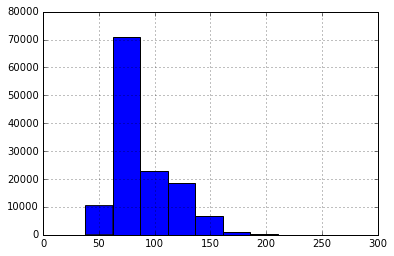

In [303]:
%matplotlib inline

import pandas as pd

import pickle


df = pd.read_csv('../data/CleanData/all_2014_15_16.csv')


from clean_data import *



map_codes = {'378': 'F',
            '393': 'E',
            '394': 'B',
            '398': 'I',
            '399': 'A',
            '400': 'J',
            '404': 'G',
            '406': 'C',
            '407': 'D',
            '408': 'L',
            '410': 'H',
            '411': 'K',
            '392': 'T'
}

src_cols = ['Zwolle_bb_01a',
 'Zwolle_bb_01b',
 'Zwolle_bb_02a',
 'Zwolle_bb_02b',
 'Zwolle_bb_03a',
 'Zwolle_bb_03b',
 'Zwolle_bb_04a',
 'Zwolle_bb_04b',
 'Zwolle_bb_05a',
 'Zwolle_bb_05b',
 'Zwolle_bb_06a',
 'Zwolle_bb_06b',
 'Zwolle_bb_07a',
 'Zwolle_bb_07b',
 'Zwolle_bb_08a',
 'Zwolle_bb_08b',
 'Zwolle_bb_09a',
 'Zwolle_bb_09b',
 'Zwolle_bb_11a',
 'Zwolle_bb_11b',
 'Zwolle_bb_12a',
 'Zwolle_bb_12b',
 'Zwolle_bb_13a',
 'Zwolle_bb_13b',
 'Zwolle_bb_14a',
 'Zwolle_bb_14b',
 'Zwolle_bb_15a',
 'Zwolle_bb_15b',
 'Zwolle_bb_16a',
 'Zwolle_bb_16b',
 'Zwolle_bb_17a',
 'Zwolle_bb_17b',
 'Zwolle_bb_18a',
 'Zwolle_bb_18b',
 'Zwolle_bb_19a',
 'Zwolle_bb_19b',
 'Zwolle_bb_20a',
 'Zwolle_bb_20b',
 'Zwolle_bb_21a',
 'Zwolle_bb_21b',
 'Zwolle_bb_22a',
 'Zwolle_bb_22b',
 'Zwolle_bb_23a',
 'Zwolle_bb_23b',
 'Zwolle_bb_24a',
 'Zwolle_bb_24b',
 'Zwolle_bb_25a',
 'Zwolle_bb_25b',
 'Zwolle_bb_26a',
 'Zwolle_bb_26b',
 'Zwolle_bb_27a',
 'Zwolle_bb_27b',
 'Zwolle_bb_28a',
 'Zwolle_bb_28b',
 'Zwolle_bb_29a',
 'Zwolle_bb_29b',
 'Zwolle_bb_30a',
 'Zwolle_bb_30b',
 'Zwolle_bb_31a',
 'Zwolle_bb_31b']

tgt_cols = ['R_vbm399_394',
 'R_vbm394_399',
 'R_vbm321_407',
 'R_vbm407_321',
 'R_vbm394_393',
 'R_vbm393_394',
 'R_vbm394_408',
 'R_vbm408_394',
 'R_vbm408_409',
 'R_vbm409_408',
 'R_vbm409_390',
 'R_vbm390_409',
 'R_vbm390_403',
 'R_vbm403_390',
 'R_vbm389_284',
 'R_vbm284_389',
 'R_vbm390_389',
 'R_vbm389_390',
 'R_vbm389_387',
 'R_vbm387_389',
 'R_vbm387_388',
 'R_vbm388_387',
 'R_vbm388_391',
 'R_vbm391_388',
 'R_vbm391_395',
 'R_vbm395_391',
 'R_vbm391_276',
 'R_vbm276_391',
 'R_vbm276_400',
 'R_vbm400_276',
 'R_vbm391_397',
 'R_vbm397_391',
 'R_vbm392_397',
 'R_vbm397_392',
 'R_vbm388_392',
 'R_vbm392_388',
 'R_vbm392_411',
 'R_vbm411_392',
 'R_vbm411_410',
 'R_vbm410_411',
 'R_vbm411_378',
 'R_vbm378_411',
 'R_vbm393_378',
 'R_vbm378_393',
 'R_vbm378_404',
 'R_vbm404_378',
 'R_vbm404_322',
 'R_vbm322_404',
 'R_vbm410_404',
 'R_vbm404_410',
 'R_vbm410_398',
 'R_vbm398_410',
 'R_vbm398_283',
 'R_vbm283_398',
 'R_vbm393_407',
 'R_vbm407_393',
 'R_vbm407_406',
 'R_vbm406_407',
 'R_vbm406_394',
 'R_vbm394_406']

m = defaultdict(str)
m.update({src: tgt_cols[i] for i, src in enumerate(src_cols)})
trymap = lambda c: m[c] or c


mins_diff=100

df.columns = [change_header(c) for c in df.columns]
df.columns = [change_header(c) for c in df.columns]

y = (df.B_A > 100)[mins_diff:]

df = df.iloc[:-mins_diff,:]

df['y'] = y

df = df.dropna(axis=0)

y = df['y'].values.astype(int)
del df['y']

del df['tijd']
del df['Unnamed: 0']

df.B_A.hist()


In [ ]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)


len(X_train)

from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier


params = dict(
    max_depth=[20, 30, 40],
    n_estimators=[10, 30, 50],
    max_features=[10, 30, 50]
)

score = 'f1'

clf = GridSearchCV(
    RandomForestClassifier(),  
    param_grid=params,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring=score,  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=3),  # what type of cross validation to use
)

clf.fit(X_train, y_train)

y_true, y_pred = y_test, clf.predict(X_test)

clf.best_params_

print(classification_report(y_true, y_pred))

